In [8]:
import numpy as np
import pandas as pd
import pickle
import random
from tqdm import tqdm
from time import time

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy

from DIN import DIN
from data_crecate import create_amazon_electronic_dataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""数据生成"""
file_name = './dataset/remap.pkl'
feature_columns, behavior_list, (train_X, train_y), (val_X, val_y), (test_X, test_y) = create_amazon_electronic_dataset(file_name)

=========Data Preprocess Start===========


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12991.31it/s]


=================Padding================
===========Data Preprocess End====================


In [3]:
"""超参数设置"""
maxlen = 40
embed_dim = 8
att_hidden_units = [80, 40]
ffn_hidden_units = [256, 128, 64]
dnn_dropout = 0.5
att_activation = 'sigmoid'
ffn_activation = 'prelu'

learning_rate = 0.001
batch_size = 64
epochs = 50

In [4]:
"""模型建立"""
model = DIN(feature_columns, behavior_list, att_hidden_units, ffn_hidden_units, att_activation, ffn_activation, maxlen, dnn_dropout)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None,)              0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 40)           0           input_3[0][0]                    
______________________________________________________________________________________________

In [5]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

In [6]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)  # 调整学习率
]
history = model.fit(train_X, 
                    train_y, 
                    epochs=epochs, 
                    validation_data=(val_X, val_y), 
                    batch_size=batch_size,
                    callbacks = callbacks
                   )

Epoch 1/50
303/303 [==============================] - 3s 6ms/step - loss: 0.5946 - auc: 0.7442 - val_loss: 0.7480 - val_auc: 0.8460
Epoch 2/50
303/303 [==============================] - 1s 5ms/step - loss: 0.1950 - auc: 0.9783 - val_loss: 0.4486 - val_auc: 0.8951
Epoch 3/50
303/303 [==============================] - 1s 5ms/step - loss: 0.0513 - auc: 0.9986 - val_loss: 0.7335 - val_auc: 0.8884
Epoch 4/50
303/303 [==============================] - 1s 5ms/step - loss: 0.0252 - auc: 0.9997 - val_loss: 0.9171 - val_auc: 0.8756
Epoch 5/50
303/303 [==============================] - 1s 5ms/step - loss: 0.0234 - auc: 0.9996 - val_loss: 0.9259 - val_auc: 0.8732

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/50
303/303 [==============================] - 2s 5ms/step - loss: 0.0255 - auc: 0.9995 - val_loss: 0.8943 - val_auc: 0.8764
Epoch 7/50
303/303 [==============================] - 1s 5ms/step - loss: 0.0177 - auc: 0.9999 - val_loss: 0.8851 - val_auc: 0

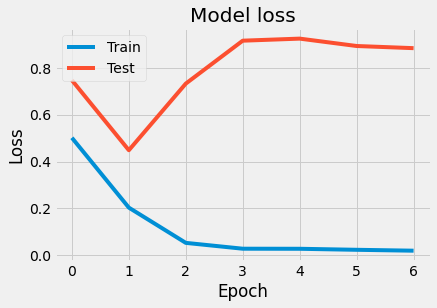

In [9]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

这里发现1个epoch的时候，后面就开始过拟合了。我这次用的数据量太小了。

In [10]:
"""模型评估"""
print('test AUC: %f' % model.evaluate(test_X, test_y)[1])

1054/1054 [==============================] - 1s 1ms/step - loss: 1.1714 - auc: 0.6439
test AUC: 0.643948
